# Import relevant libraries and files

In [2]:

from triqlerParser import *
from triqlerProcessor import * 
from utils import * 
from parseReformattedPSSS3equDecoy import * # Needs to tidy and place functions in right place!
from corrPlot import * #correlation plotting

import os
import pandas as pd
import numpy as np
from scipy import stats
import scipy as sp
import subprocess
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("whitegrid", {'axes.grid' : False})#, 'grid.color': '.1', 'grid.linestyle': u'-'})

Load triqler to dataframe, add species and protein columns and treshold on 0.01 FDR.

In [3]:
triqler = table2Df("PSSS3_triqler_output_proteins.1vs10.tsv", peptideSeperator = True)
triqler = triqler2Numeric(triqler)
triqler = getTriqlerDetailed(triqler)


# FDR on protein_id_posterior_error_prob
triqler.sort_values(by = "protein_id_posterior_error_prob", inplace = True)
triqler["FDR"] = triqler["protein_id_posterior_error_prob"].expanding().mean()
triqler = triqler[triqler["FDR"] < 0.01]
df_triqler = triqler




/home/ptruong/Git/mergespec/bin/triqler+spectronaut/triqlerProcessor.py:523: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  triqler = triqler.convert_objects(convert_numeric = True)
/home/ptruong/.local/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Get samples for the different species.

In [4]:

# All runs
at_t = df_triqler[df_triqler["specie"] == "ARATH"]
ce_t = df_triqler[df_triqler["specie"] == "CAEEL"]
hs_t = df_triqler[df_triqler["specie"] == "HUMAN"]

# DROP species and drop peptides 
at_t = renameTriqler2Vital(at_t)
ce_t = renameTriqler2Vital(ce_t)
hs_t = renameTriqler2Vital(hs_t)

/home/ptruong/Git/mergespec/bin/triqler+spectronaut/triqlerProcessor.py:335: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df = df.convert_objects(convert_numeric=True)


Do the same process for PSSS3. 

In [5]:
psss3 = pd.read_table('500-PSSS3-precursor_Report.proteins.tsv')
df_psss3 = addSpecieProteinColumns(psss3, startRun = "S01:S01_R01", endRun = "S10:S10_R05")

at_s = df_psss3[df_psss3["specie"] == "ARATH"]
ce_s = df_psss3[df_psss3["specie"] == "CAEEL"]
hs_s = df_psss3[df_psss3["specie"] == "HUMAN"]

at_s = renameTriqler2Vital_nonDetailed(at_s)
ce_s = renameTriqler2Vital_nonDetailed(ce_s)
hs_s = renameTriqler2Vital_nonDetailed(hs_s)

/home/ptruong/anaconda3/envs/py36_PSSS3+triqler/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.
/home/ptruong/Git/mergespec/bin/triqler+spectronaut/triqlerProcessor.py:313: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df = df.convert_objects(convert_numeric=True)


If we want to use the unfiltered PSSS3 data. We can change the above read in to this. 

In [38]:
#read-in
df = parsePSSS3equDecoy(filename = '500-PSSS3-equ decoy_Report.xls') # VERY SLOW



In [ ]:
# Drop duplicates
#df = reformatted_df.drop_duplicates()

#Treshold without removing NaN
#df.fillna(-1, inplace = True)
#FDR_treshold = 0.05
#df = df[df["qvalue"]<FDR_treshold]
#df.replace(-1, np.NaN, inplace = True)

#decoy = df["decoy"].apply(lambda x: "decoy_" if x == True else "")
#df["protein"] = decoy+df["protein"]

#df_reform = getTriqlerOutputFormat_from_reformattedRawPSSS3(df)

#df_multiIdx = triqlerFormat2multiIndex(df_reform)
#df_multiIdx = multiIdxFillna_min(df_multiIdx) #mean imputation #<--- IMPUTATION STEP

#df_multiIdx = df_multiIdx.dropna(thresh = len(df_multiIdx.iloc[0]))

#psss3 = multiIndex2TriqlerFormat(df_multiIdx)

#psss3.reset_index(level=0, inplace = True)
#df_psss3 = addSpecieProteinColumns(psss3, startRun = "S01:S01_R01", endRun = "S10:S10_R05")
#df_psss3 = df_psss3.dropna()

#at_s = df_psss3[df_psss3["specie"] == "ARATH"]
#ce_s = df_psss3[df_psss3["specie"] == "CAEEL"]
#hs_s = df_psss3[df_psss3["specie"] == "HUMAN"]

#at_s = renameTriqler2Vital_nonDetailed(at_s)
#ce_s = renameTriqler2Vital_nonDetailed(ce_s)
#hs_s = renameTriqler2Vital_nonDetailed(hs_s)

Protein count per species and method.

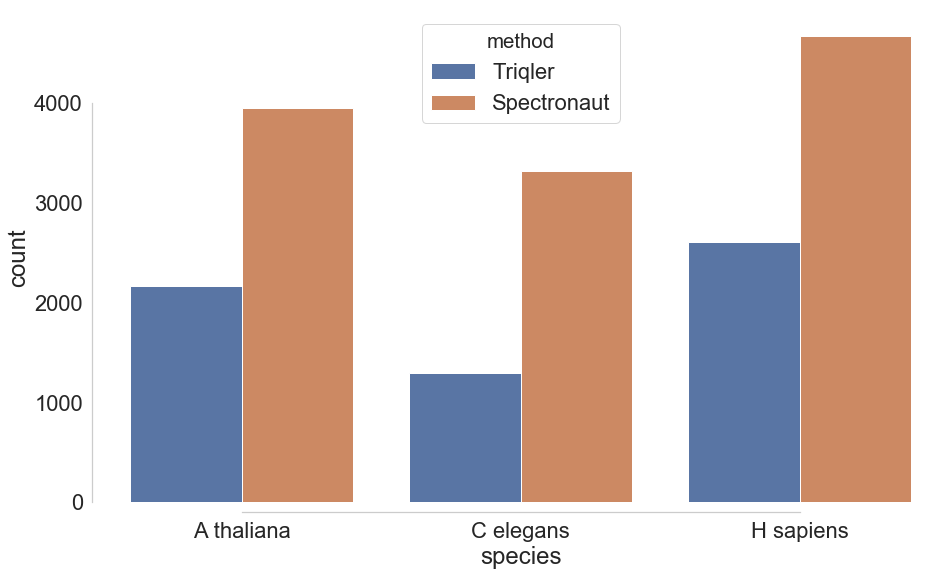

In [8]:
protein_count = pd.DataFrame(columns = ['species', 'method'])
protein_count['species'] = (['A thaliana']*len(at_t) + ['C elegans']*len(ce_t) + ["H sapiens"]*len(hs_t) + 
             ['A thaliana']*len(at_s) + ['C elegans']*len(ce_s) + ["H sapiens"]*len(hs_s))
protein_count['method'] = (['Triqler']*len(at_t) + ['Triqler']*len(ce_t) + ['Triqler']*len(hs_t) + 
             ['Spectronaut']*len(at_s) + ['Spectronaut']*len(ce_s) + ['Spectronaut']*len(hs_s))

fig, ax = plt.subplots(figsize=(15, 9))
sns.countplot(x='species', hue='method', data=protein_count)
sns.despine(offset=10, trim=True);
plt.show()


Normalize to per-protein abundance for spectronaut.

In [9]:

repl_cols = ["S01","S02","S03","S04","S05","S06","S07","S08","S09","S10"]

normalized_protein_at_s = at_s.div(at_s.sum(axis=1), axis=0)
normalized_protein_ce_s = ce_s.div(ce_s.sum(axis=1), axis=0)
normalized_protein_hs_s = hs_s.div(hs_s.sum(axis=1), axis=0)

Merge normalized spectronaut species.

In [10]:
sampgroup_at_s,sampgroup_hs_s,sampgroup_ce_s = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

for s in repl_cols:
    sampgroup_at_s[s] = normalized_protein_at_s[s].sum(1)
    sampgroup_ce_s[s] = normalized_protein_ce_s[s].sum(1)
    sampgroup_hs_s[s] = normalized_protein_hs_s[s].sum(1)
    
sampgroup_at_s['Species'] = ['A thaliana'] *len(normalized_protein_at_s)
sampgroup_ce_s['Species'] = ['C elegans']  *len(normalized_protein_ce_s)
sampgroup_hs_s['Species'] = ['H sapiens']  *len(normalized_protein_hs_s)
sampgroup_at_s['Method']  = ['Spectronaut']*len(normalized_protein_at_s)
sampgroup_ce_s['Method']  = ['Spectronaut']*len(normalized_protein_ce_s)
sampgroup_hs_s['Method']  = ['Spectronaut']*len(normalized_protein_hs_s)

sampgroup_spec_s = pd.concat([sampgroup_at_s,sampgroup_ce_s,sampgroup_hs_s])

Do the same process for Triqler data.

In [11]:
normalized_protein_at_t = at_t.div(at_t.sum(axis=1), axis=0)
normalized_protein_ce_t = ce_t.div(ce_t.sum(axis=1), axis=0)
normalized_protein_hs_t = hs_t.div(hs_t.sum(axis=1), axis=0)

sampgroup_at_t,sampgroup_hs_t,sampgroup_ce_t = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

for t in repl_cols:
    sampgroup_at_t[t] = normalized_protein_at_t[t].sum(1)
    sampgroup_ce_t[t] = normalized_protein_ce_t[t].sum(1)
    sampgroup_hs_t[t] = normalized_protein_hs_t[t].sum(1)
    
sampgroup_at_t['Species'] = ['A thaliana'] *len(normalized_protein_at_t)
sampgroup_ce_t['Species'] = ['C elegans']  *len(normalized_protein_ce_t)
sampgroup_hs_t['Species'] = ['H sapiens']  *len(normalized_protein_hs_t)
sampgroup_at_t['Method']  = ['Triqler']*len(normalized_protein_at_t)
sampgroup_ce_t['Method']  = ['Triqler']*len(normalized_protein_ce_t)
sampgroup_hs_t['Method']  = ['Triqler']*len(normalized_protein_hs_t)

sampgroup_spec_t = pd.concat([sampgroup_at_t,sampgroup_ce_t,sampgroup_hs_t])


Merge the data.

In [12]:
sampgroup = sampgroup_spec_t
sampgroup = sampgroup_spec_s
sampgroup = sampgroup_spec_t.append(sampgroup_spec_s)

sampgroup.where((pd.notnull(sampgroup)), np.NaN,inplace=True)
sampgroup.dropna(inplace=True)

sampgroup['Protein'] = range(len(sampgroup))

unmeltsamp = sampgroup.copy() #copy to be used later.
sampgroup=pd.melt(sampgroup, id_vars=['Method', 'Species','Protein'], value_vars=repl_cols)
sampgroup.rename(columns={'variable':'Sample','value':'Expression'}, inplace=True)


Define the true mixtures.

In [13]:
a_mix = np.array([0.5] * 10)
a_mix[0] += 0.0001
c_mix = np.array([0.5, 0.25, 0.125, 0.0625, 0.031, 0.0155, 0.008, 0.004, 0.002, 0.0])
h_mix = np.array([0.0, 0.25, 0.375, 0.4375, 0.469, 0.4845, 0.492, 0.496, 0.498, 0.5])
a_mix = a_mix/a_mix.sum()
c_mix = c_mix/c_mix.sum()
h_mix = h_mix/h_mix.sum()
mix = {'A thaliana':a_mix, 'C elegans': c_mix, 'H sapiens': h_mix}

# Plotting

Homo Sapiens.

Text(0.5, 1.0, 'Homo sapiens')

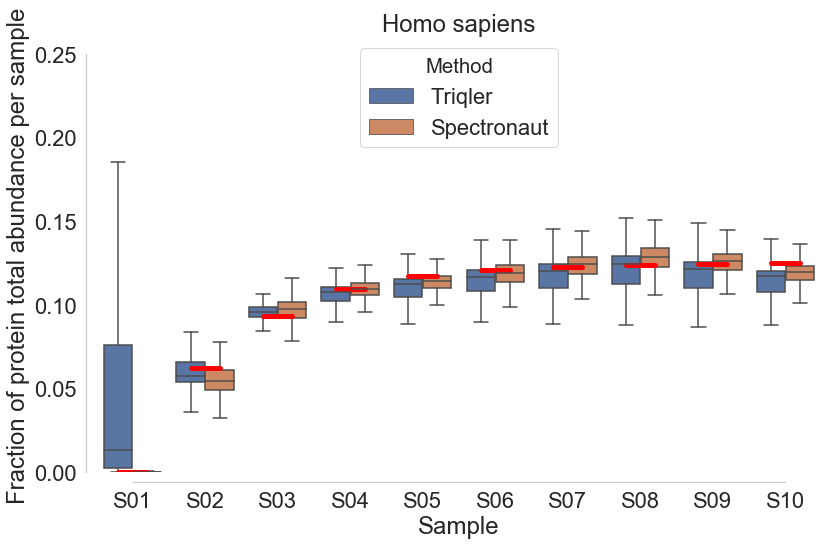

In [14]:
fig, ax = plt.subplots(figsize=(13, 8))
#sns.violinplot(data=sampgroup.loc[sampgroup['Species'] == "H sapiens"], x="Sample",y="Expression", hue="Method",split=True)
sns.boxplot(data=sampgroup.loc[sampgroup['Species'] == "H sapiens"], x="Sample",y="Expression", hue="Method",fliersize=0)
for i in range(len(h_mix)):
    ax.plot([i-.2, i+.2], [h_mix[i], h_mix[i]], '-', color='red', lw=5)
ax.set_ylim(0,0.26)
ax.set_ylabel("Fraction of protein total abundance per sample")
sns.despine(offset=10, trim=True)
plt.title("Homo sapiens")

Caenorhabditis Elegans.

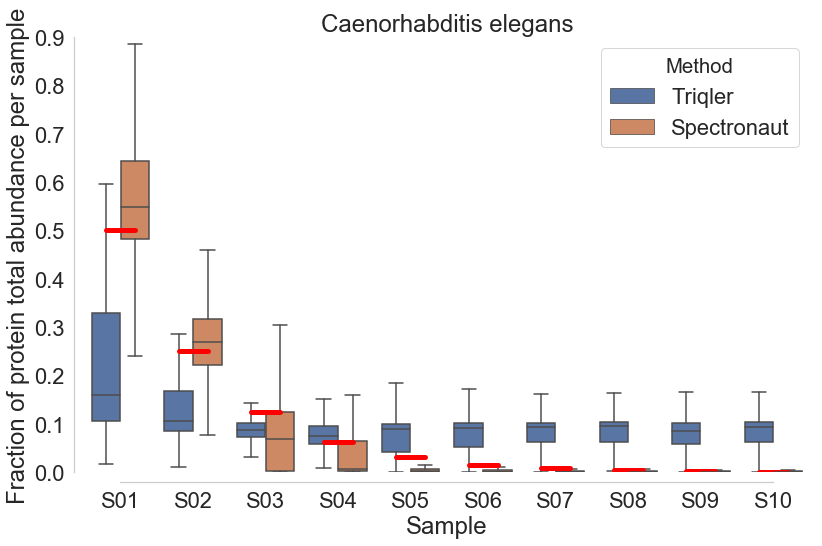

In [15]:

fig, ax = plt.subplots(figsize=(13, 8))
#sns.violinplot(data=sampgroup.loc[sampgroup['Species'] == "H sapiens"], x="Sample",y="Expression", hue="Method",split=True)
sns.boxplot(data=sampgroup.loc[sampgroup['Species'] == "C elegans"], x="Sample",y="Expression", hue="Method",fliersize=0)
for i in range(len(c_mix)):
    ax.plot([i-.2, i+.2], [c_mix[i], c_mix[i]], '-', color='red', lw=5)
ax.set_ylim(0,0.9)
ax.set_ylabel("Fraction of protein total abundance per sample")
plt.title('Caenorhabditis elegans')
sns.despine(offset=10, trim=True)

Arabidopsis thaliana.

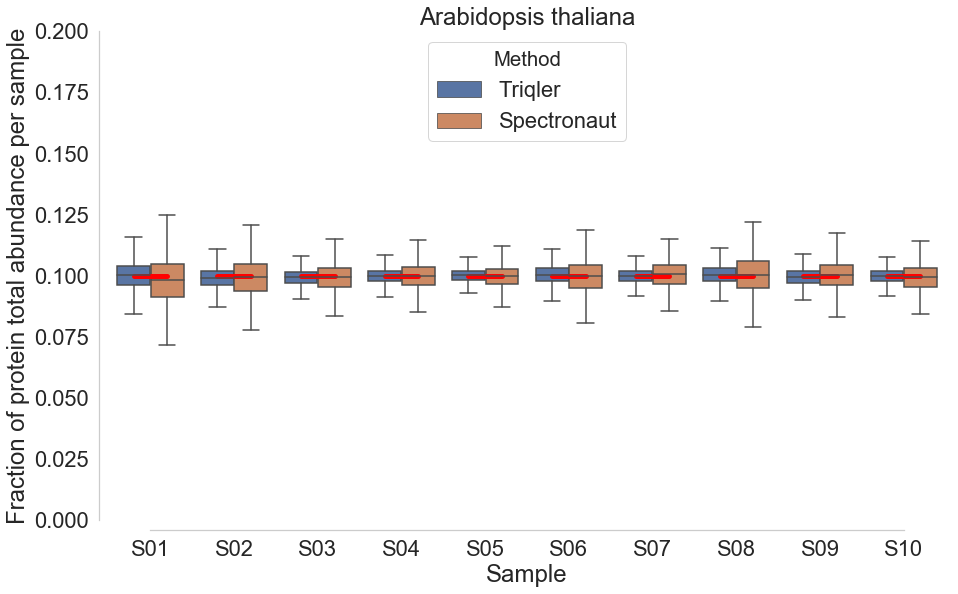

In [16]:
fig, ax = plt.subplots(figsize=(15, 9)) 
#sns.violinplot(data=sampgroup.loc[sampgroup['Species'] == "H sapiens"], x="Sample",y="Expression", hue="Method",split=True)
sns.boxplot(data=sampgroup.loc[sampgroup['Species'] == "A thaliana"], x="Sample",y="Expression", hue="Method",fliersize=0)
for i in range(len(a_mix)):
    ax.plot([i-.2, i+.2], [a_mix[i], a_mix[i]], '-', color='red', lw=5)
ax.set_ylim(0,0.2)
ax.set_ylabel("Fraction of protein total abundance per sample")
plt.title('Arabidopsis thaliana')
sns.despine(offset=10, trim=True)



In [33]:
# CORRELATION PLOTTING FUNCTIONS.
from scipy.stats.stats import pearsonr
from numpy import log10



def my_corr(row):
    a_mix = np.array([0.5] * 10)
    a_mix[0] += 0.0001
    c_mix = np.array([0.5, 0.25, 0.125, 0.0625, 0.031, 0.0155, 0.008, 0.004, 0.002, 0.0])
    h_mix = np.array([0.0, 0.25, 0.375, 0.4375, 0.469, 0.4845, 0.492, 0.496, 0.498, 0.5])
    a_mix = a_mix/a_mix.sum()
    c_mix = c_mix/c_mix.sum()
    h_mix = h_mix/h_mix.sum()
    mix = {'A thaliana':a_mix, 'C elegans': c_mix, 'H sapiens': h_mix}
    mymix = mix[row['Species']]
    row = row.loc[repl_cols]
    ixs = (row != 0.0)
    a = np.array(row.loc[ixs])
    b = mymix[ixs]
    return pearsonr(a,b)[0]

def p_r_plot(species,figname=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    N=5000
    for meth in unmeltsamp['Method'].unique():
        sns.distplot(unmeltsamp[(unmeltsamp['Method']==meth) & (unmeltsamp['Species']==species)]['Correlation, R'],
             hist_kws={"cumulative":-1, "linewidth": 3, "alpha": 1,"histtype": "step"},
             bins=N, kde=False, ax=ax, label=meth, norm_hist = True)
    ax.set_xlim(-0.9,1.0)
    ax.set_ylim(0,1.2)
    ax.set_title(species)
    sns.despine(offset=10, trim=True)
    ax.set_ylabel("Number of proteins")
    ax.set_xlabel("Cumulative samples "r"$\leq$" " correlation coefficient")
    plt.legend()
    if figname:
        fig.savefig(figname)

Correlation plots.

add correlation to dataframe.

In [34]:
unmeltsamp['Correlation, R'] = unmeltsamp.apply(my_corr, axis=1)
unmeltsamp.dropna(inplace=True)
#unmeltsamp.isna().sum().sum()
unmeltsamp.isnull().sum().sum()


0

Homo Sapiens.

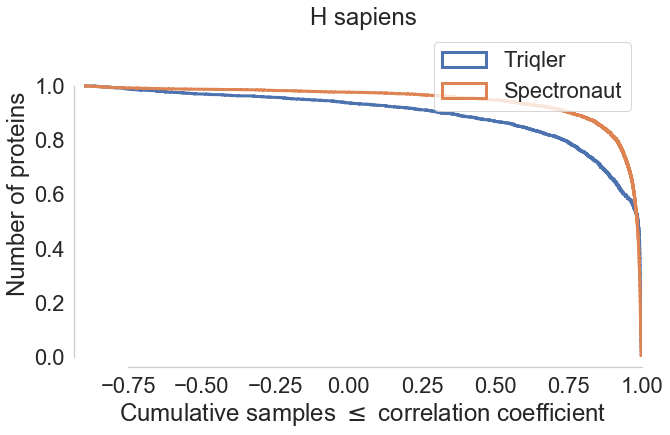

In [35]:
p_r_plot('H sapiens')


Caenorhabditis Elegans.

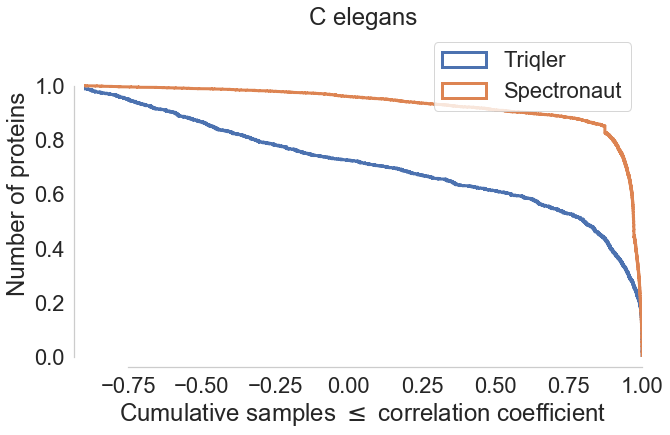

In [36]:
p_r_plot('C elegans')


Arabidopsis thaliana.

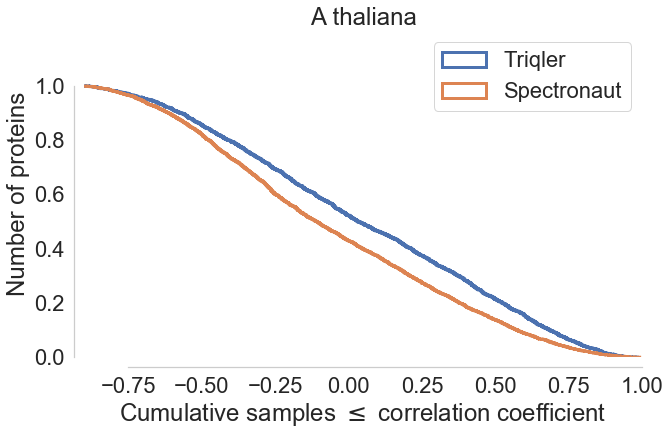

In [37]:
p_r_plot('A thaliana')
